# Physical Models

To train the neural networks, all the physical models are simulated. Then, a localization error is added. 
All the simulated data is adapted to the specific size of the camera and the frame rate. The constant values for each model or the range of values used were selected from previous research data.

When simulating a trajectory, all the models return 2D data (x,y), time data (t) and 2D with localization error added. Also, in the case of the Two-State Diffusion, the states vector and a switching behavior flag is returned. This helps for the segmentation network output. In all the cases, the only valid simulations for training are the ones with switching behavior because individually, the first state is free diffusion and the second is obstructed diffusion in a lattice, our goal is to simulate a two-state model.

---

In [19]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt

# Camera parameter
FILE_pixel_size = 106 # nm

### Localization error 

The noise is created using random gaussian values with mean=40 nm and standard deviation=10 nm

In [11]:
def add_noise(track_length):
    # New error formula
    mean_error = 40
    sigma_error = 10
    error_x = np.random.normal(loc=mean_error / 2, scale=sigma_error / 2, size=track_length)
    error_x_sign = np.random.choice([-1, 1], size=track_length)
    error_y = np.random.normal(loc=mean_error / 2, scale=sigma_error / 2, size=track_length)
    error_y_sign = np.random.choice([-1, 1], size=track_length)
    return error_x * error_x_sign, error_y * error_y_sign


def add_noise_and_offset(track_length, x, y):
    noise_x, noise_y = add_noise(track_length)
    x_noisy = x + noise_x
    y_noisy = y + noise_y
    if np.min(x_noisy) < np.min(x) and np.min(x_noisy) < 0:
        min_noisy_x = np.absolute(np.min(x_noisy))
        x_noisy = x_noisy + min_noisy_x  # Convert to positive
        x = x + min_noisy_x
    if np.min(x_noisy) > np.min(x) and np.min(x) < 0:
        min_x = np.absolute(np.min(x))
        x_noisy = x_noisy + min_x  # Convert to positive
        x = x + min_x
    if np.min(y_noisy) < np.min(y) and np.min(y_noisy) < 0:
        min_noisy_y = np.absolute(np.min(y_noisy))
        y_noisy = y_noisy + min_noisy_y  # Convert to positive
        y = y + min_noisy_y
    if np.min(y_noisy) > np.min(y) and np.min(y) < 0:
        min_y = np.absolute(np.min(y))
        y_noisy = y_noisy + min_y  # Convert to positive
        y = y + min_y
    offset_x = np.ones(shape=track_length) * np.random.uniform(low=0, high=(
            10000 - np.minimum(np.max(x), np.max(x_noisy))))
    offset_y = np.ones(shape=track_length) * np.random.uniform(low=0, high=(
            10000 - np.minimum(np.max(y), np.max(y_noisy))))
    x = x + offset_x
    y = y + offset_y
    x_noisy = x_noisy + offset_x
    y_noisy = y_noisy + offset_y
    return x, x_noisy, y, y_noisy


### Fractional Brownian Motion (fBm)

In [12]:
class FBM():
    sub_diff_min_max = [0.1, 0.42]
    super_diff_min_max = [0.58, 0.9]

    def __init__(self, hurst_exp):
        self.hurst_exp = hurst_exp

    @classmethod
    def create_random(cls):
        fbm_type = np.random.choice([0,1,2])
        if fbm_type == 0:
            model = cls.create_random_subdiffusive()
        elif fbm_type == 1:
            model = cls.create_random_superdiffusive()
        else:
            model = cls.create_random_brownian()
        return model

    @classmethod
    def create_random_superdiffusive(cls, hurst_exp=None):
        if hurst_exp is not None:
            assert (cls.super_diff_min_max[0] <= hurst_exp <= cls.super_diff_min_max[
                1]), "Invalid Hurst Exponent"
            model = cls(hurst_exp=hurst_exp)

        else:
            random_hurst_exp = np.random.uniform(low=cls.super_diff_min_max[0], high=cls.super_diff_min_max[1])
            model = cls(hurst_exp=random_hurst_exp)
        return model

    @classmethod
    def create_random_subdiffusive(cls, hurst_exp=None):
        if hurst_exp is not None:
            assert (cls.sub_diff_min_max[0] <= hurst_exp <= cls.sub_diff_min_max[
                1]), "Invalid Hurst Exponent"
            model = cls(hurst_exp=hurst_exp)
        else:
            random_hurst_exp = np.random.uniform(low=cls.sub_diff_min_max[0], high=cls.sub_diff_min_max[1])
            model = cls(hurst_exp=random_hurst_exp)
        return model

    @classmethod
    def create_random_brownian(cls, use_exact_exp=False):
        if use_exact_exp:
            model = cls(hurst_exp=0.5)
        else:
            random_brownian_hurst_exp = np.random.uniform(low=cls.sub_diff_min_max[1], high=cls.super_diff_min_max[0])
            model = cls(hurst_exp=random_brownian_hurst_exp)
        return model

    def simulate_track(self, track_length, track_time):

        r = np.zeros(track_length + 1)  # first row of circulant matrix
        r[0] = 1
        idx = np.arange(1, track_length + 1, 1)
        r[idx] = 0.5 * ((idx + 1) ** (2 * self.hurst_exp) - 2 * idx ** (2 * self.hurst_exp) + (idx - 1) ** (
                2 * self.hurst_exp))
        r = np.concatenate((r, r[np.arange(len(r) - 2, 0, -1)]))

        # get eigenvalues through fourier transform
        lamda = np.real(fftpack.fft(r)) / (2 * track_length)

        # get trajectory using fft: dimensions assumed uncoupled
        x = fftpack.fft(np.sqrt(lamda) * (
                np.random.normal(size=(2 * track_length)) + 1j * np.random.normal(size=(2 * track_length))))
        x = track_length ** (-self.hurst_exp) * np.cumsum(np.real(x[:track_length]))  # rescale
        x = ((track_time ** self.hurst_exp) * x)  # resulting trajectory in x

        y = fftpack.fft(np.sqrt(lamda) * (
                np.random.normal(size=(2 * track_length)) + 1j * np.random.normal(size=(2 * track_length))))
        y = track_length ** (-self.hurst_exp) * np.cumsum(np.real(y[:track_length]))  # rescale
        y = ((track_time ** self.hurst_exp) * y)  # resulting trajectory in y

        # Scale to 10.000 nm * 10.000 nm
        if np.min(x) < 0:
            x = x + np.absolute(np.min(x))  # Add offset to x
        if np.min(y) < 0:
            y = y + np.absolute(np.min(y))  # Add offset to y

        # Scale to nm and add a random offset
        x = x * FILE_pixel_size
        y = y * FILE_pixel_size

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = np.linspace(0, track_time, track_length)

        return x_noisy, y_noisy, x, y, t

    def get_diffusion_type(self):
        if self.sub_diff_min_max[0] <= self.hurst_exp <= self.sub_diff_min_max[1]:
            return "Subdiffusive"
        elif self.sub_diff_min_max[1] < self.hurst_exp < self.super_diff_min_max[0]:
            return "Brownian"
        else:
            return "Superdiffusive"

#### Plot example of FBM



Current Hurst Exponent(H): 0.36
fBm type: Subdiffusive


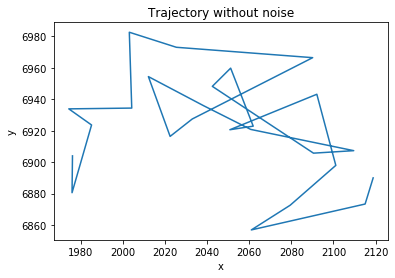

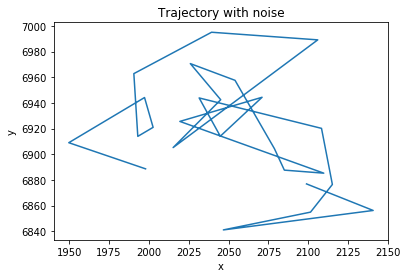

In [13]:
fbm = FBM.create_random()
x_n, y_n, x, y, t = fbm.simulate_track(track_length=25, track_time=0.5)

print('\n\nCurrent Hurst Exponent(H): {:.2f}'.format(fbm.hurst_exp))
print('fBm type: {}'.format(fbm.get_diffusion_type()))
plt.plot(x,y)
plt.title('Trajectory without noise')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(x_n,y_n)
plt.title('Trajectory with noise')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Continuous Time Random Walk (CTRW)

In [14]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


class CTRW():
    min_alpha = 0.1
    max_alpha = 0.9

    def __init__(self, alpha):
        assert (self.min_alpha <= alpha <= self.max_alpha), "Invalid alpha parameter"
        self.alpha = alpha
        self.beta = 0.5
        self.gamma = 1

    @classmethod
    def create_random(cls):
        random_alpha = np.random.uniform(low=cls.min_alpha, high=cls.max_alpha)
        model = cls(alpha=random_alpha)
        return model

    def mittag_leffler_rand(self, track_length):
        # Generate mittag-leffler random numbers
        t = -np.log(np.random.uniform(size=[track_length, 1]))
        u = np.random.uniform(size=[track_length, 1])
        w = np.sin(self.beta * np.pi) / np.tan(self.beta * np.pi * u) - np.cos(self.beta * np.pi)
        t = t * (w ** 1 / self.beta)
        t = self.gamma * t
        return t

    def symmetric_alpha_levy(self, track_length):
        alpha_levy_dist = 2
        gamma_levy_dist = self.gamma ** (self.alpha / 2)
        # Generate symmetric alpha-levi random numbers
        u = np.random.uniform(size=[track_length, 1])
        v = np.random.uniform(size=[track_length, 1])

        phi = np.pi * (v - 0.5)
        w = np.sin(alpha_levy_dist * phi) / np.cos(phi)
        z = -1 * np.log(u) * np.cos(phi)
        z = z / np.cos((1 - alpha_levy_dist) * phi)
        x = gamma_levy_dist * w * z ** (1 - (1 / alpha_levy_dist))

        return x

    def simulate_track(self, track_length, track_time):

        jumps_x = self.mittag_leffler_rand(track_length)
        raw_time_x = np.cumsum(jumps_x)
        t_x = raw_time_x * track_time / np.max(raw_time_x)
        t_x = np.reshape(t_x, [len(t_x), 1])

        jumps_y = self.mittag_leffler_rand(track_length)
        raw_time_y = np.cumsum(jumps_y)
        t_y = raw_time_y * track_time / np.max(raw_time_y)
        t_y = np.reshape(t_y, [len(t_y), 1])

        x = self.symmetric_alpha_levy(track_length)
        x = np.cumsum(x)
        x = np.reshape(x, [len(x), 1])

        y = self.symmetric_alpha_levy(track_length)
        y = np.cumsum(y)
        y = np.reshape(y, [len(y), 1])

        t_out = np.arange(0, track_length, 1) * track_time / track_length
        x_out = np.zeros([track_length, 1])
        y_out = np.zeros([track_length, 1])
        for i in range(track_length):
            x_out[i, 0] = x[find_nearest(t_x, t_out[i]), 0]
            y_out[i, 0] = y[find_nearest(t_y, t_out[i]), 0]

        x = x_out[:, 0]
        y = y_out[:, 0]
        t = t_out

        # Scale to 10.000 nm * 10.000 nm
        if np.min(x) < 0:
            x = x + np.absolute(np.min(x))  # Add offset to x
        if np.min(y) < 0:
            y = y + np.absolute(np.min(y))  # Add offset to y
        # Scale to nm and add a random offset
        x = x * FILE_pixel_size / 10
        y = y * FILE_pixel_size / 10

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        return x_noisy, y_noisy, x, y, t


#### Plot example of CTRW

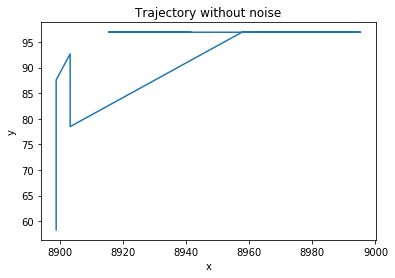

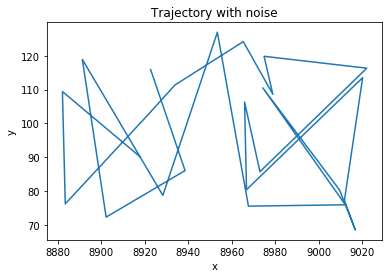

In [15]:
ctrw = CTRW.create_random()
x_n, y_n, x, y, t = ctrw.simulate_track(track_length=25, track_time=0.5)

plt.plot(x,y)
plt.title('Trajectory without noise')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(x_n,y_n)
plt.title('Trajectory with noise')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Two-State Diffusion (Free and Obstructed Diffusion)

In [16]:
class TwoStateObstructedDiffusion():
    """
    State-0: Free Diffusion
    State-1: Obstructed Diffusion
    """
    d0_low = 0.05
    d0_high = 0.2
    k0_low = 0.01
    k0_high = 0.08
    k1_low = 0.007
    k1_high = 0.2

    def __init__(self, k_state0, k_state1, d_state0):
        self.k_state0 = k_state0
        self.k_state1 = k_state1
        self.D_state0 = d_state0 * 1000000  # Convert from um^2 -> nm^2

    @classmethod
    def create_random(cls):
        # k_state(i) dimensions = 1 / frame
        # D_state(i) dimensions = um^2 * s^(-beta)
        d_state0 = np.random.uniform(low=cls.d0_low, high=cls.d0_high)
        k_state0 = np.random.uniform(low=cls.k0_low, high=cls.k0_high)
        k_state1 = np.random.uniform(low=cls.k1_low, high=cls.k1_high)
        model = cls(k_state0, k_state1, d_state0)
        return model

    @classmethod
    def create_with_coefficients(cls, k_state0, k_state1, d_state0):
        assert (d_state0 > 0), "Invalid Diffusion coefficient state-0"
        assert (k_state0 > 0), "Invalid switching rate state-0"
        assert (k_state0 > 0), "Invalid switching rate state-1"
        return cls(k_state0, k_state1, d_state0)

    def get_d_state0(self):
        return self.D_state0 / 1000000

    def normalize_d_coefficient_to_net(self, state_number):
        assert (state_number == 0), "Not a valid state"
        delta_d0 = self.d0_high - self.d0_low
        return (1 / delta_d0) * (self.get_d_state0() - self.d0_low)

    @classmethod
    def denormalize_d_coefficient_to_net(cls, output_coefficient_net):
        delta_d0 = cls.d0_high - cls.d0_low
        return output_coefficient_net * delta_d0 + cls.d0_low

    def simulate_track(self, track_length, track_time):
        x = np.zeros(shape=track_length)
        y = np.zeros(shape=track_length)

        state, switching = self.simulate_switching_states(track_length)

        if state[0] == 1:
            x[0] = np.random.normal(loc=0, scale=5)
            y[0] = np.random.normal(loc=0, scale=5)
        else:
            x[0] = np.random.normal(loc=0, scale=1)
            y[0] = np.random.normal(loc=0, scale=1)

        i = 1
        while i < track_length:
            while state[i] == 0 and i < track_length:
                jumps_x = np.random.normal(loc=0, scale=1)
                jumps_y = np.random.normal(loc=0, scale=1)
                x[i] = x[i - 1] + (jumps_x * np.sqrt(2 * self.D_state0 * (track_time / track_length)))
                y[i] = y[i - 1] + (jumps_y * np.sqrt(2 * self.D_state0 * (track_time / track_length)))
                i += 1
                if i >= track_length:
                    break

            confinement_flag = True
            if i >= track_length:
                break
            while state[i] == 1 and i < track_length:
                if confinement_flag:
                    confinement_region_min_x, confinement_region_max_x = self.simulate_confinement_region(x[i - 1])
                    confinement_region_min_y, confinement_region_max_y = self.simulate_confinement_region(y[i - 1])
                    confinement_flag = False

                jumps_x = np.random.normal(loc=0, scale=5)
                jumps_y = np.random.normal(loc=0, scale=5)

                if jumps_x > 0:
                    if x[i - 1] + jumps_x > confinement_region_max_x:
                        x[i] = x[i - 1]
                    else:
                        x[i] = x[i - 1] + jumps_x
                else:
                    if x[i - 1] + jumps_x < confinement_region_min_x:
                        x[i] = x[i - 1]
                    else:
                        x[i] = x[i - 1] + jumps_x

                if jumps_y > 0:
                    if y[i - 1] + jumps_y > confinement_region_max_y:
                        y[i] = y[i - 1]
                    else:
                        y[i] = y[i - 1] + jumps_y

                else:
                    if y[i - 1] + jumps_y < confinement_region_min_y:
                        y[i] = y[i - 1]
                    else:
                        y[i] = y[i - 1] + jumps_y

                i += 1
                if i >= track_length:
                    break

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = self.simulate_tract_time(track_length, track_time)

        return x_noisy, y_noisy, x, y, t, state, switching

    def simulate_track_only_state0(self, track_length, track_time):
        x = np.random.normal(loc=0, scale=1, size=track_length)
        y = np.random.normal(loc=0, scale=1, size=track_length)

        for i in range(track_length):
            x[i] = x[i] * np.sqrt(2 * self.D_state0 * (track_time / track_length))
            y[i] = y[i] * np.sqrt(2 * self.D_state0 * (track_time / track_length))

        x = np.cumsum(x)
        y = np.cumsum(y)

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = self.simulate_tract_time(track_length, track_time)

        return x_noisy, y_noisy, x, y, t

    def simulate_track_only_state1(self, track_length, track_time):
        initial_pos_x = np.random.normal(loc=0, scale=5)
        initial_pos_y = np.random.normal(loc=0, scale=5)

        confinement_region_min_x, confinement_region_max_x = self.simulate_confinement_region(initial_pos_x)
        confinement_region_min_y, confinement_region_max_y = self.simulate_confinement_region(initial_pos_y)

        x = np.zeros(shape=track_length)
        y = np.zeros(shape=track_length)

        jumps_x = np.random.normal(loc=0, scale=5, size=track_length)
        jumps_y = np.random.normal(loc=0, scale=5, size=track_length)

        x[0], y[0] = initial_pos_x, initial_pos_y

        for i in range(1, track_length):
            if jumps_x[i] > 0:
                if x[i - 1] + jumps_x[i] > confinement_region_max_x:
                    x[i] = x[i - 1]
                else:
                    x[i] = x[i - 1] + jumps_x[i]

            else:
                if x[i - 1] + jumps_x[i] < confinement_region_min_x:
                    x[i] = x[i - 1]
                else:
                    x[i] = x[i - 1] + jumps_x[i]

            if jumps_y[i] > 0:
                if y[i - 1] + jumps_y[i] > confinement_region_max_y:
                    y[i] = y[i - 1]
                else:
                    y[i] = y[i - 1] + jumps_y[i]

            else:
                if y[i - 1] + jumps_y[i] < confinement_region_min_y:
                    y[i] = y[i - 1]
                else:
                    y[i] = y[i - 1] + jumps_y[i]

        x, x_noisy, y, y_noisy = add_noise_and_offset(track_length, x, y)

        t = self.simulate_tract_time(track_length, track_time)

        return x_noisy, y_noisy, x, y, t

    def simulate_tract_time(self, track_length, track_time):
        t = np.linspace(0, track_time, track_length)
        return t

    def simulate_confinement_region(self, initial_pos):
        confinement_region_size = np.random.uniform(low=20, high=40)
        offset_region = initial_pos + np.random.uniform(low=(-confinement_region_size / 2),
                                                        high=(confinement_region_size / 2))

        confinement_region_max = offset_region + (confinement_region_size / 2)
        confinement_region_min = offset_region - (confinement_region_size / 2)

        return confinement_region_min, confinement_region_max

    def simulate_switching_states(self, track_length):
        # Residence time
        res_time0 = 1 / self.k_state0
        res_time1 = 1 / self.k_state1

        # Compute each t_state according to exponential laws
        t_state0 = np.random.exponential(scale=res_time0, size=track_length)
        t_state1 = np.random.exponential(scale=res_time1, size=track_length)

        # Set initial t_state for each state
        t_state0_next = 0
        t_state1_next = 0

        # Pick an initial state from a random choice
        current_state = np.random.choice([0, 1])

        # Detect real switching behavior
        switching = ((current_state == 0) and (int(np.ceil(t_state0[t_state0_next])) < track_length)) or (
                (current_state == 1) and (int(np.ceil(t_state1[t_state1_next])) < track_length))

        # Fill state array
        state = np.zeros(shape=track_length)
        i = 0

        while i < track_length:
            if current_state == 1:
                current_state_length = int(np.ceil(t_state1[t_state1_next]))

                if (current_state_length + i) < track_length:
                    state[i:(i + current_state_length)] = np.ones(shape=current_state_length)
                else:
                    state[i:track_length] = np.ones(shape=(track_length - i))

                current_state = 0  # Set state from 1->0
            else:
                current_state_length = int(np.ceil(t_state0[t_state0_next]))
                current_state = 1  # Set state from 0->1

            i += current_state_length

        return state, switching


In [17]:
def plot_with_states(x, y, states, title):
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    
    for i in range(len(states)):
        if states[i] == 0:
            plt.scatter(x[i], y[i], c='r')
        else:
            plt.scatter(x[i], y[i], c='b')
    plt.show()

#### Plot example of Two-State Diffusion



Blue dots: Obstructed diffusion
Red dots: Free Diffusion


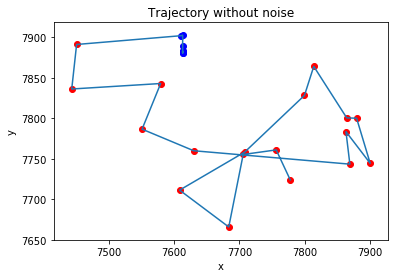

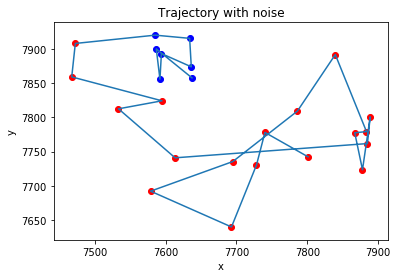

In [22]:
two_state = TwoStateObstructedDiffusion.create_random()
x_n, y_n, x, y, t, states,switching = two_state.simulate_track(track_length=25, track_time=0.5)

print('\n\nBlue dots: Obstructed diffusion')
print('Red dots: Free Diffusion')

plot_with_states(x, y, states, 'Trajectory without noise')

plot_with_states(x_n, y_n, states, 'Trajectory with noise')
